<a href="https://colab.research.google.com/github/RicardoMourao-py/BigData-Dados-Publicos/blob/main/projeto_bigdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data para Dados Públicos

- Ricardo Mourão
- Rodrigo Lima
- Ykaro de Andrade

<center>

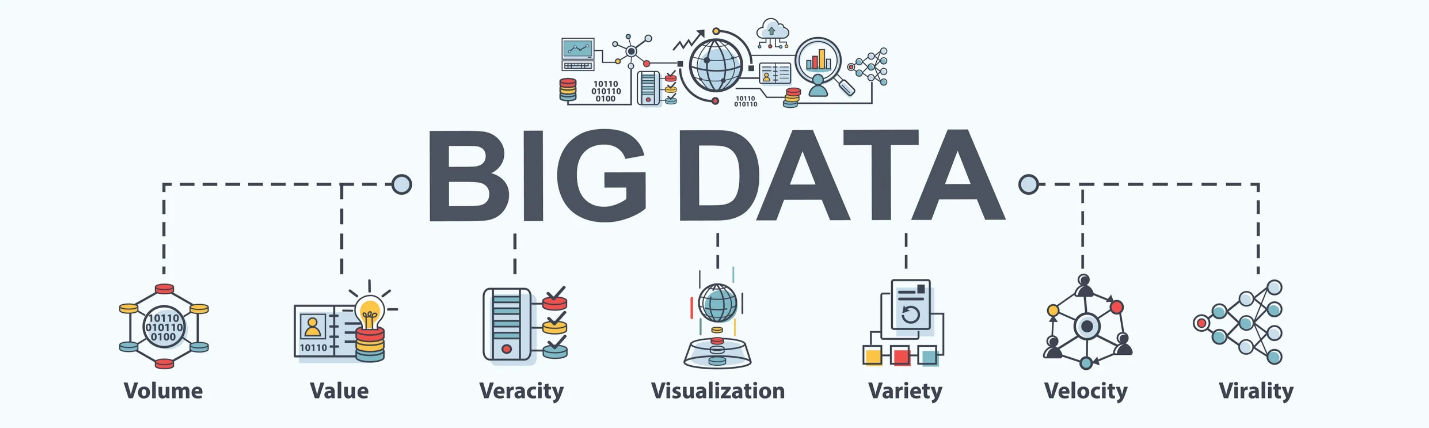

Este projeto consiste na análise de dados públicos e o uso de boas práticas de BigData. Sendo assim, foi garantido o trabalho com dados em larga escala e o seu processamento de forma adequada. Além disso, essas foram as principais ferramentas utilizadas:

- **ETL**: Uso de selenium e beutifulsoup para a extração dos dados, uso de bibliotecas python para transformações e carregamento dos dados no Datalake.
- **BigQuery**: Ambiente de armazenamento de dados totalmente gerenciado e sem servidor do Google. Nele foi possível armazenar os dados coletados para uma melhor análise com o uso de query's.
- **Spark**: responsável pelo processamento em larga escala e com suas ferramentas fazer um análise exploratória adequada.

Os dados públicos escolhido foram os disponíveis no [Portal da Transparência](https://portaldatransparencia.gov.br/download-de-dados/despesas-favorecidos) sobre Recebimento de recursos por favorecido. Nele, é possível visualizar informações sobre favorecidos de despesas públicas, ou seja, quanto determinados Órgãos receberam ao longo dos anos. Entre os favorecidos temos: entes governamentais, entidades sem fins lucrativos, demais pessoas jurídicas ou pessoas físicas que receberam transferências de recursos públicos federais, independentemente da origem desses valores.

Fonte: Controladoria-Geral da União

A amostra de dados considerou os anos de 2014 até 2022, na qual isso resultou aproximadamente em 80 milhões de dados. Contudo, devido a limitações orçamentárias, o conjunto de dados foi reduzido em cerga de 1 milhão de dados para que sua análise possa ser feita neste notebook.

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive')
project = 'bigdata-dados-publicos' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

Mounted at /content/drive


# Bibliotecas Necessárias

In [ ]:
!git clone https://github.com/RicardoMourao-py/BigData-Dados-Publicos.git
!pip install -r /content/BigData-Dados-Publicos/requirements.txt

Cloning into 'BigData-Dados-Publicos'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 9), reused 9 (delta 2), pack-reused 0
Receiving objects: 100% (26/26), 19.12 KiB | 9.56 MiB/s, done.
Resolving deltas: 100% (9/9), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 25.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845494 sha256=256f6238b5bf492a71c865b08e365bc784c1924d467f14f77bbb2265e84e16a7
  Stored in directory: /root/.cache/pip/wheels/0f/f0/3d/517368b8ce80486e84f89f214e0a022554e4ee64969f46279b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, to_date, sum, substring, desc, rank, countDistinct, count, avg, stddev, min, max, year
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## SQL usado para extração dos dados
Use o ```jobs.query```,
[método](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) para
retornar a sintaxe SQL do trabalho. Isso pode ser copiado da célula de saída
abaixo para editar a consulta agora ou no futuro. Alternativamente, você pode usar
[este link](https://console.cloud.google.com/bigquery?j=bigdata-dados-publicos:US:bquxjob_73a773cf_18bf4f815d8)
volte ao BigQuery para editar a consulta na interface do usuário do BigQuery.

In [ ]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_73a773cf_18bf4f815d8') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT * FROM `bigdata-dados-publicos.DS_PORTAL_TRANSPARENCIA.TB_DESPESAS_FAVORECIDOS_DISTRIBUIDA` 


# Conjunto de resultados carregado como um DataFrame

### Inicialização dos dados e Tratamento

In [ ]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Iniciando com Spark') \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [ ]:
dados = spark.read.csv("/content/drive/MyDrive/Projeto BigData/dados_publicos.csv")

In [ ]:
# Definindo schema da tabela
dados = dados.selectExpr("_c0 as CODIGO_FAVORECIDO",
                         "_c1 as NOME_FAVORECIDO",
                         "_c2 as SIGLA_UF",
                         "_c3 as NOME_MUNICIPIO",
                         "_c4 as CODIGO_ORGAO_SUPERIOR",
                         "_c5 as NOME_ORGAO_SUPERIOR",
                         "_c6 as CODIGO_ORGAO",
                         "_c7 as NOME_ORGAO",
                         "_c8 as CODIGO_UNIDADE_GESTORA",
                         "_c9 as NOME_UNIDADE_GESTORA",
                         "_c10 as ANO_E_MES_DO_LANCAMENTO",
                         "_c11 as VALOR_RECEBIDO")

In [ ]:
# remove primeira linha (indesejada) do dataframe
first_row = dados.first()
dados = dados.filter(col("CODIGO_FAVORECIDO") != first_row["CODIGO_FAVORECIDO"])
dados.show(10)

+-----------------+--------------------+--------+--------------+---------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+--------------+
|CODIGO_FAVORECIDO|     NOME_FAVORECIDO|SIGLA_UF|NOME_MUNICIPIO|CODIGO_ORGAO_SUPERIOR| NOME_ORGAO_SUPERIOR|CODIGO_ORGAO|          NOME_ORGAO|CODIGO_UNIDADE_GESTORA|NOME_UNIDADE_GESTORA|ANO_E_MES_DO_LANCAMENTO|VALOR_RECEBIDO|
+-----------------+--------------------+--------+--------------+---------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+--------------+
|   04045993000179|MUNICIPIO DE ASSI...|      AC|  ASSIS BRASIL|                52000|Ministério da Defesa|       52000|Ministério da Def...|                110594|DEPARTAMENTO DO P...|                05/2022|     430800,00|
|   01575860000116|AUTO POSTO ACRELA...|      AC|    ACRELÂNDIA|                47000|Ministério do 

In [ ]:
dados.printSchema()

root
 |-- CODIGO_FAVORECIDO: string (nullable = true)
 |-- NOME_FAVORECIDO: string (nullable = true)
 |-- SIGLA_UF: string (nullable = true)
 |-- NOME_MUNICIPIO: string (nullable = true)
 |-- CODIGO_ORGAO_SUPERIOR: string (nullable = true)
 |-- NOME_ORGAO_SUPERIOR: string (nullable = true)
 |-- CODIGO_ORGAO: string (nullable = true)
 |-- NOME_ORGAO: string (nullable = true)
 |-- CODIGO_UNIDADE_GESTORA: string (nullable = true)
 |-- NOME_UNIDADE_GESTORA: string (nullable = true)
 |-- ANO_E_MES_DO_LANCAMENTO: string (nullable = true)
 |-- VALOR_RECEBIDO: string (nullable = true)



In [ ]:
dados = dados.withColumn("VALOR_RECEBIDO", regexp_replace(col("VALOR_RECEBIDO"), ",", ".").cast("float"))
dados = dados.withColumn("ANO_E_MES_DO_LANCAMENTO", to_date(col("ANO_E_MES_DO_LANCAMENTO"), "MM/yyyy"))

In [ ]:
dados.show(10)

+-----------------+--------------------+--------+--------------+---------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+--------------+
|CODIGO_FAVORECIDO|     NOME_FAVORECIDO|SIGLA_UF|NOME_MUNICIPIO|CODIGO_ORGAO_SUPERIOR| NOME_ORGAO_SUPERIOR|CODIGO_ORGAO|          NOME_ORGAO|CODIGO_UNIDADE_GESTORA|NOME_UNIDADE_GESTORA|ANO_E_MES_DO_LANCAMENTO|VALOR_RECEBIDO|
+-----------------+--------------------+--------+--------------+---------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+--------------+
|   04045993000179|MUNICIPIO DE ASSI...|      AC|  ASSIS BRASIL|                52000|Ministério da Defesa|       52000|Ministério da Def...|                110594|DEPARTAMENTO DO P...|             2022-05-01|      430800.0|
|   01575860000116|AUTO POSTO ACRELA...|      AC|    ACRELÂNDIA|                47000|Ministério do 

**Código Favorecido**: Código do favorecido do pagamento realizado. Favorecidos: Entes governamentais, entidades sem fins lucrativos, demais pessoas jurídicas ou pessoas físicas que receberam transferências de recursos públicos federais, independentemente da origem desses valores.

**Nome Favorecido**: Nome do favorecido do pagamento realizado

**Sigla UF**: Sigla da Unidade Federativa do favorecido do recurso

**Nome Município**: Nome do município do favorecido do recurso

**Código Órgão Superior**: Código do Órgão Superior responsável pela despesa

**Nome Órgão Superior**: Nome do Órgão Superior responsável pela despesa

**Código Órgão**: Código do Órgão responsável pela despesa

**Nome Órgão**: Nome do Órgão responsável pela despesa

**Código Unidade Gestora** Código da Unidade Gestora responsável pela despesa. UNIDADE GESTORA (UG) - Unidade Orçamentária ou Administrativa que realiza atos de gestão orçamentária, financeira e/ou patrimonial, cujo titular, em consequência, está sujeito a tomada de contas anual.

**Nome Unidade Gestora**: Nome da Unidade Gestora responsável pela despesa

**Ano e mês do lançamento**: Ano e mês em que foi realizado o lançamento

**Valor Recebido**: Valor do recebimento


# Análise Exploratória

### Estatísticas Descritivas do Valor Recebido

In [ ]:
dados.describe('VALOR_RECEBIDO').show()

+-------+-------------------+
|summary|     VALOR_RECEBIDO|
+-------+-------------------+
|  count|             999972|
|   mean|  202343.6626021604|
| stddev|4.589236224528552E7|
|    min|      -1.67795942E9|
|    max|       3.3693268E10|
+-------+-------------------+



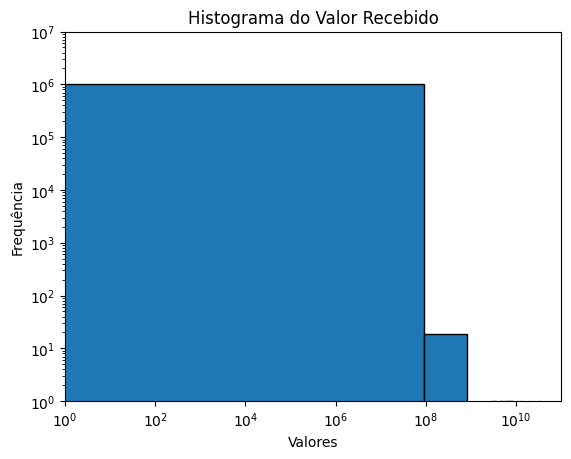

In [ ]:
hist_data = dados.select(col("VALOR_RECEBIDO")).rdd.flatMap(lambda x: x).histogram(50)

# Extraindo os bins e as frequências
bins = hist_data[0]
frequencias = hist_data[1]

# Plotando o histograma usando matplotlib
plt.bar(bins[:-1], frequencias, width=np.diff(bins), edgecolor='black')

# Adicionando rótulos e título ao gráfico
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Histograma do Valor Recebido')
plt.yscale('log')
plt.ylim(1, 1e7)
plt.xscale('log')
plt.xlim(1, 1e11)
# Exibindo o histograma
plt.show()

Perceba no gráfico acima que a escala ainda pode ser melhorada e isso resultará em uma melhor visualização da distribuição de frequências.

### Análise da distribuição dos valores recebidos por cada Unidade Federativa

In [ ]:
# Adiciona uma coluna para extrair o estado da sigla UF
df_por_estado = dados.withColumn("ESTADO", substring(dados["SIGLA_UF"], 1, 2))

# Agrega os valores por Unidade Federativa
resultado_por_estado = df_por_estado.groupBy("ESTADO").agg(sum("VALOR_RECEBIDO").alias("VALOR_TOTAL"))

# Exibe o resultado
resultado_por_estado.show()

+------+--------------------+
|ESTADO|         VALOR_TOTAL|
+------+--------------------+
|    -1|1.851530101666005...|
|    EX| 4.188982063236595E9|
|    RR| 5.539807948614717E8|
|    AL| 2.081241749797484E9|
|    AC|  9.03260533520478E9|
|    AP| 6.240378772015643E8|
|    AM| 6.858621718237232E8|
|    BA|1.8276820888043582E7|
+------+--------------------+



Observe que a UF EX geralmente especifíca despesas gastas com o exterior.

### Principais Favorecidos em termos de valor recebido e Análise de Padrões.

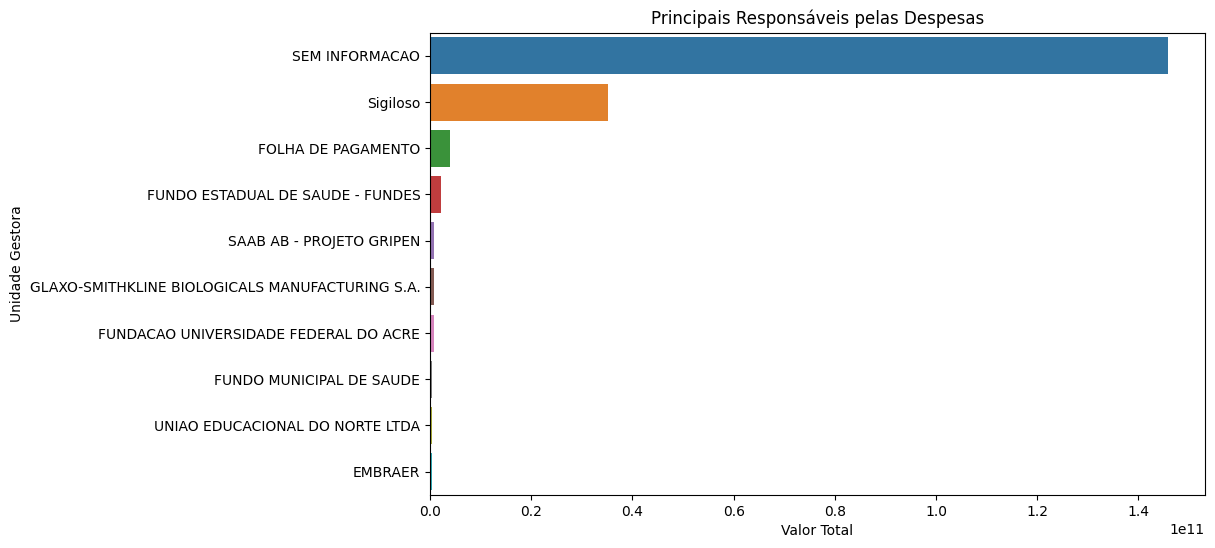


Padrões de Pagamento:
+-----------------------------------------------------------------------------------+----------------------+---------------+--------------------+
|NOME_FAVORECIDO                                                                    |NUM_UNIDADES_DISTINTAS|NUM_LANCAMENTOS|MEDIA_VALOR_RECEBIDO|
+-----------------------------------------------------------------------------------+----------------------+---------------+--------------------+
|EDNALDO SANTOS DE SOUSA JUNIOR                                                     |2                     |9              |278.4699999491374   |
|ERASMO CANDIDO DA SILVA                                                            |1                     |1              |3854.39990234375    |
|SAYONARA IVANA SANTOS DE ASSIS                                                     |1                     |4              |477.5               |
|GARDAWORLD SECURITY SERVICES                                                       |1               

In [ ]:
top_favorecidos = dados.groupBy("CODIGO_FAVORECIDO", "NOME_FAVORECIDO").agg(sum("VALOR_RECEBIDO").alias("VALOR_TOTAL"))

# Ordenando os favorecidos pelo valor total em ordem decrescente
window_spec = Window.orderBy(desc("VALOR_TOTAL"))
top_favorecidos = top_favorecidos.withColumn("rank", rank().over(window_spec))

# Selecionando os principais favorecidos (os top 10)
top_10_favorecidos = top_favorecidos.filter("rank <= 10").drop("rank")

# Converte para Pandas
df_pandas = top_10_favorecidos.toPandas()

# Plotando o gráfico de barras com Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="VALOR_TOTAL", y="NOME_FAVORECIDO", data=df_pandas)
plt.title("Principais Responsáveis pelas Despesas")
plt.xlabel("Valor Total")
plt.ylabel("Unidade Gestora")
plt.show()

# Analisando se há algum padrão específico nos pagamentos para esses favorecidos
# Exemplo: Agrupando por NOME_FAVORECIDO e analisando os padrões de pagamento
padroes_pagamento = dados.groupBy("NOME_FAVORECIDO").agg(
    countDistinct("CODIGO_UNIDADE_GESTORA").alias("NUM_UNIDADES_DISTINTAS"),
    count("ANO_E_MES_DO_LANCAMENTO").alias("NUM_LANCAMENTOS"),
    avg("VALOR_RECEBIDO").alias("MEDIA_VALOR_RECEBIDO")
)

print("\nPadrões de Pagamento:")
padroes_pagamento.show(truncate=False)

### Explorando a Distribuição dos Valores por Órgão Superior e Órgão.

In [ ]:
dist_por_orgao_superior = dados.groupBy("CODIGO_ORGAO_SUPERIOR", "NOME_ORGAO_SUPERIOR") \
    .agg(sum("VALOR_RECEBIDO").alias("VALOR_TOTAL"))

print("Distribuição dos valores por órgão superior:")
dist_por_orgao_superior.show(truncate=False)

# Distribuição dos valores por órgão
dist_por_orgao = dados.groupBy("CODIGO_ORGAO", "NOME_ORGAO") \
    .agg(sum("VALOR_RECEBIDO").alias("VALOR_TOTAL"))

print("Distribuição dos valores por órgão:")
dist_por_orgao.show(truncate=False)

Distribuição dos valores por órgão superior:
+---------------------+---------------------------------------------+--------------------+
|CODIGO_ORGAO_SUPERIOR|NOME_ORGAO_SUPERIOR                          |VALOR_TOTAL         |
+---------------------+---------------------------------------------+--------------------+
|44000                |Ministério do Meio Ambiente e Mudança do Clim|3.37920963353138E7  |
|22000                |Ministério da Agricultura, Pecuária e Abastec|3.7900610334291425E9|
|49000                |Ministério do Desenvolvimento Agrário        |5.1577638009441406E7|
|25201                |Banco Central do Brasil - Orçamento Fiscal e |2514163.661315918   |
|25000                |Ministério da Fazenda                        |6.15104707393065E8  |
|55000                |Ministério do Desenvolvimento e Assistência S|5.3830397321388245E7|
|26000                |Ministério da Educação                       |8.516074455979915E9 |
|53000                |Ministério da Integraç

### Identificando os Principais Responsáveis pelas Despesas.

In [ ]:
# Identificando os principais responsáveis pelas despesas
top_responsaveis = dados.groupBy("CODIGO_UNIDADE_GESTORA", "NOME_UNIDADE_GESTORA").agg(
    sum("VALOR_RECEBIDO").alias("VALOR_TOTAL")
)

# Ordenando os responsáveis pelo valor total em ordem decrescente
window_spec = Window.orderBy(desc("VALOR_TOTAL"))
top_responsaveis = top_responsaveis.withColumn("rank", rank().over(window_spec))

# Selecionando os principais responsáveis (os top 10)
top_10_responsaveis = top_responsaveis.filter("rank <= 10").drop("rank")

# Exibindo os principais responsáveis
print("Principais Responsáveis pelas Despesas:")
top_10_responsaveis.show(truncate=False)

Principais Responsáveis pelas Despesas:
+----------------------+---------------------------------------------+--------------------+
|CODIGO_UNIDADE_GESTORA|NOME_UNIDADE_GESTORA                         |VALOR_TOTAL         |
+----------------------+---------------------------------------------+--------------------+
|170600                |COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA    |7.633581372310172E10|
|170502                |SECRETARIA DO TESOURO NACIONAL/COFIN/STN     |4.113686354125018E10|
|200334                |COORDENACAO GERAL DE ADMINISTRACAO CGAD/DLOG/|1.96020191426003E10 |
|200334                |COORDENACAO GERAL DE ADMINISTRAÇÃO CGAD/DLOG/|6.106348869781097E9 |
|537001                |FUNDO CONSTITUCIONAL DE FINANCIAM.DO NORDESTE|5.910017392E9       |
|257001                |DIRETORIA EXECUTIVA DO FUNDO NAC. DE SAUDE   |4.2511786993147125E9|
|806030                |SERPRO - SEDE - BRASILIA                     |4.192966369405061E9 |
|110537                |AGENCIA BRASILEI

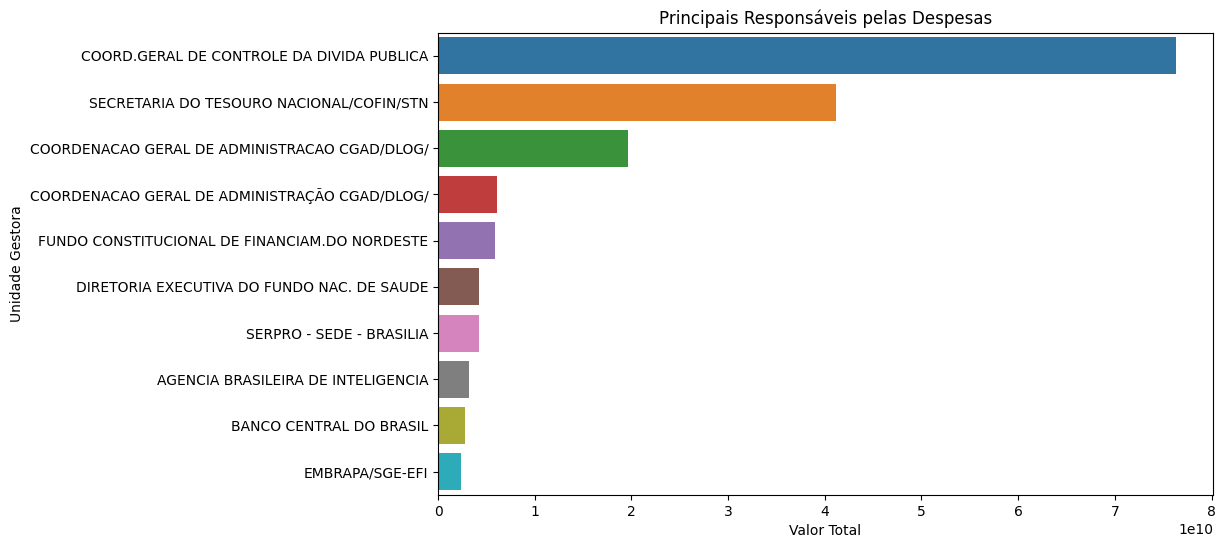

In [ ]:
# Converte para Pandas
df_pandas = top_10_responsaveis.toPandas()

# Plotando o gráfico de barras com Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="VALOR_TOTAL", y="NOME_UNIDADE_GESTORA", data=df_pandas)
plt.title("Principais Responsáveis pelas Despesas")
plt.xlabel("Valor Total")
plt.ylabel("Unidade Gestora")
plt.show()

### Calculando Estatísticas Descritivas para o Valor Recebido Agrupado por Unidade Gestora.

In [ ]:
df_unidade_gestora = dados.select("CODIGO_UNIDADE_GESTORA", "NOME_UNIDADE_GESTORA", "VALOR_RECEBIDO")

# Agrupe os dados por unidade gestora e calcule estatísticas descritivas
estatisticas_descritivas = df_unidade_gestora.groupBy("CODIGO_UNIDADE_GESTORA", "NOME_UNIDADE_GESTORA").agg(
    count("VALOR_RECEBIDO").alias("NUMERO_TRANSACOES"),
    sum("VALOR_RECEBIDO").alias("VALOR_TOTAL"),
    avg("VALOR_RECEBIDO").alias("MEDIA_VALOR"),
    min("VALOR_RECEBIDO").alias("MIN_VALOR"),
    max("VALOR_RECEBIDO").alias("MAX_VALOR"),
    stddev("VALOR_RECEBIDO").alias("DESVPAD_VALOR")
)

# Exiba as estatísticas descritivas
print("Estatísticas Descritivas por Unidade Gestora:")
estatisticas_descritivas.show(truncate=False)

Estatísticas Descritivas por Unidade Gestora:
+----------------------+---------------------------------------------+-----------------+--------------------+-------------------+---------+-----------+------------------+
|CODIGO_UNIDADE_GESTORA|NOME_UNIDADE_GESTORA                         |NUMERO_TRANSACOES|VALOR_TOTAL         |MEDIA_VALOR        |MIN_VALOR|MAX_VALOR  |DESVPAD_VALOR     |
+----------------------+---------------------------------------------+-----------------+--------------------+-------------------+---------+-----------+------------------+
|393003                |DEPART.NAC.INFRA ESTRUTURA TRANSPORTES.      |1737             |4.378227648020258E8 |252056.85941394692 |-703777.5|1.8530896E7|1247193.9756915164|
|135098                |CAIXA ECONOMICA FEDERAL/MA                   |124              |8.73245485068164E7  |704230.2298936807  |-239850.0|1.211745E7 |1678763.2704013379|
|160501                |MUSEU HISTORICO DO EXERCITO FORTE COPACABANA |41               |75666.58715

### Valor Recebido ao Longo dos Anos

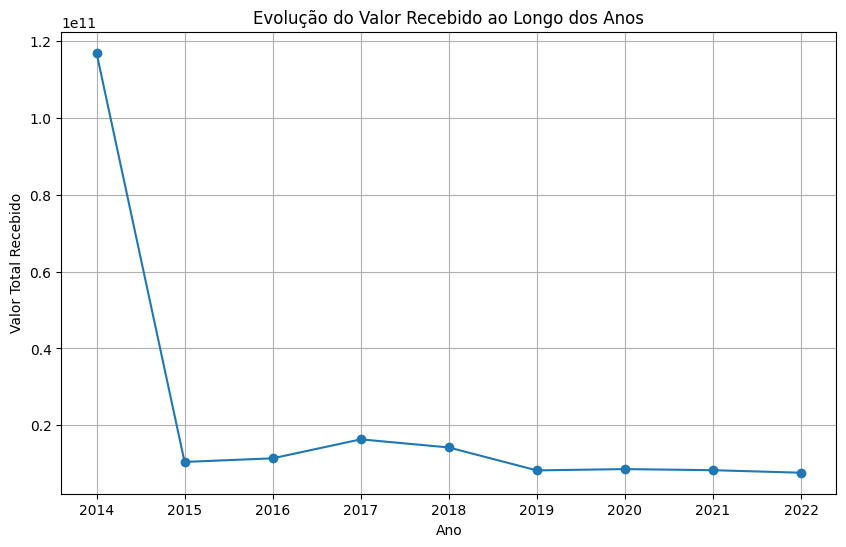

In [ ]:
# Selecione as variáveis relevantes para a análise temporal
df_evolucao_valor = dados.select("ANO_E_MES_DO_LANCAMENTO", "VALOR_RECEBIDO")

# Extraia o ano e o mês da coluna ANO_E_MES_DO_LANCAMENTO
df_evolucao_valor = df_evolucao_valor.withColumn("ANO", year("ANO_E_MES_DO_LANCAMENTO"))

# Agrupe os dados por ano e calcule o valor total recebido em cada ano
evolucao_valor_por_ano = df_evolucao_valor.groupBy("ANO").agg(
    sum("VALOR_RECEBIDO").alias("VALOR_TOTAL_ANO")
).orderBy("ANO")

# Exiba a evolução do valor recebido ao longo dos anos usando Matplotlib
anos = evolucao_valor_por_ano.select("ANO").rdd.flatMap(lambda x: x).collect()
valores_totais = evolucao_valor_por_ano.select("VALOR_TOTAL_ANO").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.plot(anos, valores_totais, marker='o', linestyle='-')
plt.title('Evolução do Valor Recebido ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Valor Total Recebido')
plt.grid(True)
plt.show()

# Conclusão

Com isso, de acordo com a nossa análise exploratória percebemos que as principais despesas brasileiras não possui informações ou são são siglosas, do acordo com a nossa amostra, ou seja, vale ressaltar que os dados não estão por completo. Além disso, vimos que a coordenadoria geral de controle da dívida pública é a principal responsável pelas despesas. Por fim, o valor recebido aos favorecidos vieram diminuindo ao longo dos anos.